In [5]:
import pandas as pd
import numpy as np
import uniprot
from Bio.SeqUtils.ProtParam import ProteinAnalysis
import matplotlib.pyplot as plt
import torch
import math
import utilities
import pickle
import seaborn as sns

In [17]:
model, alphabet = torch.hub.load("facebookresearch/esm:main", "esm1b_t33_650M_UR50S")

Using cache found in /Users/daniel/.cache/torch/hub/facebookresearch_esm_main


In [2]:
seqids, fastas = uniprot.read_fasta('/Users/daniel/desktop/cp341/uniprot_sprot.fasta')

In [6]:
#dict_you_want = { your_key: old_dict[your_key] for your_key in your_keys }
with open('human_loss.pickle', 'rb') as handle:
    human_aa_loss = pickle.load(handle) 
with open('human_counts.pickle', 'rb') as handle:
    human_aa_counts = pickle.load(handle) 
with open('mouse_loss.pickle', 'rb') as handle:
    mouse_aa_loss = pickle.load(handle) 
with open('mouse_counts.pickle', 'rb') as handle:
    mouse_aa_counts = pickle.load(handle) 
with open('bac_loss.pickle', 'rb') as handle:
    bac_aa_loss = pickle.load(handle) 
with open('bac_counts.pickle', 'rb') as handle:
    bac_aa_counts = pickle.load(handle) 
int1 = set(human_aa_counts.keys()).intersection(set(mouse_aa_counts.keys()))
int2 = int1.intersection(set(bac_aa_counts.keys()))
int2 = list(int2)
human_aa_counts = { your_key: human_aa_counts[your_key] for your_key in int2 }
human_aa_loss = { your_key: human_aa_loss[your_key] for your_key in int2 }
mouse_aa_counts = { your_key: mouse_aa_counts[your_key] for your_key in int2 }
mouse_aa_loss = { your_key: mouse_aa_loss[your_key] for your_key in int2 }
bac_aa_counts = { your_key: bac_aa_counts[your_key] for your_key in int2 }
bac_aa_loss = { your_key: bac_aa_loss[your_key] for your_key in int2 }

In [66]:
human_aa_counts

{'K': 274,
 'R': 242,
 'Y': 126,
 'S': 428,
 'W': 74,
 'V': 233,
 'G': 343,
 'D': 208,
 'E': 261,
 'F': 170,
 'A': 327,
 'H': 103,
 'I': 179,
 'N': 149,
 'P': 301,
 'C': 241,
 'L': 382,
 'M': 105,
 'Q': 170,
 'T': 210}

In [82]:
human_df = pd.DataFrame(np.array(list(human_aa_loss.values()))/np.array(list(human_aa_counts.values())))
human_df['Amino Acid'] = human_aa_counts.keys()
human_df['Species'] = ["Human"]*human_df.shape[0]
mouse_df = pd.DataFrame(np.array(list(mouse_aa_loss.values()))/np.array(list(mouse_aa_counts.values())))
mouse_df['Amino Acid']= mouse_aa_counts.keys()
mouse_df['Species'] = ["Mouse"]*mouse_df.shape[0]
bac_df = pd.DataFrame(np.array(list(bac_aa_loss.values()))/np.array(list(bac_aa_counts.values())))
bac_df['Amino Acid'] = bac_aa_counts.keys()
bac_df['Species'] = ["Bacteria"]*bac_df.shape[0]
all_df = pd.concat([human_df, mouse_df, bac_df])
all_df.columns = ['Average Cross Entropy', "Amino Acid", "Species"]
all_df

,Average Cross Entropy,Amino Acid,Species
0,3.098037,K,Human
1,3.230820,R,Human
2,3.078341,Y,Human
3,3.216091,S,Human
4,3.110405,W,Human
5,3.220921,V,Human
6,3.108887,G,Human
7,3.215859,D,Human
8,3.213460,E,Human
9,3.136998,F,Human


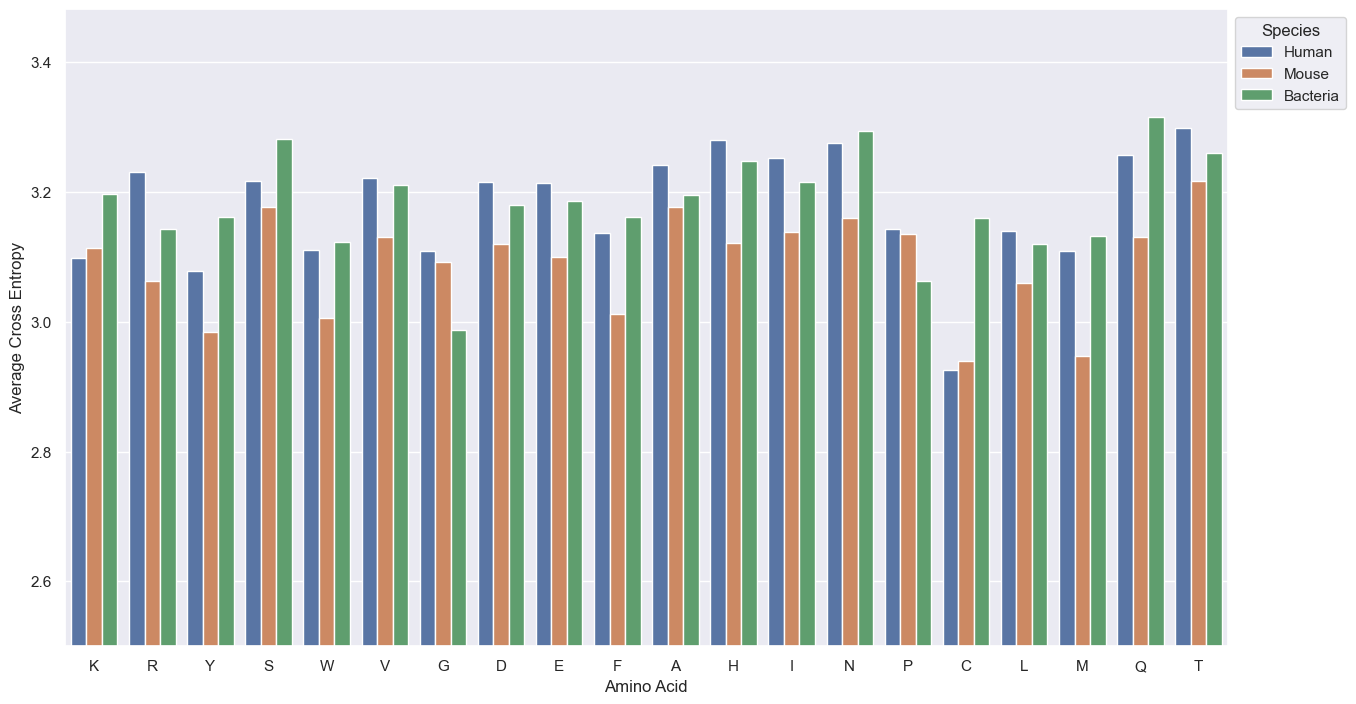

In [86]:
#sns.set(rc={'figure.figsize':(15,8.27)})
bar = sns.barplot(data=all_df, x='Amino Acid', y="Average Cross Entropy", hue='Species')
bar.set(ylim=(2.5, None))
sns.move_legend(bar, "upper left", bbox_to_anchor=(1, 1))

In [9]:
all_props = []
for aa in int2:
    props = []
    X = ProteinAnalysis(aa)
    props.append(X.aromaticity())
    props.append(X.instability_index())
    props.append(X.isoelectric_point())
    all_props.append(props)

all_props = np.array(all_props)

In [34]:
all_props

array([[0.        , 0.        , 8.75005207],
       [0.        , 0.        , 9.75002117],
       [1.        , 0.        , 5.52431812],
       [0.        , 0.        , 5.2400095 ],
       [1.        , 0.        , 5.52500019],
       [0.        , 0.        , 5.4949892 ],
       [0.        , 0.        , 5.52500019],
       [0.        , 0.        , 4.29938107],
       [0.        , 0.        , 4.59926357],
       [1.        , 0.        , 5.52500019],
       [0.        , 0.        , 5.57001667],
       [0.        , 0.        , 6.7411272 ],
       [0.        , 0.        , 5.52500019],
       [0.        , 0.        , 5.52500019],
       [0.        , 0.        , 5.95498714],
       [0.        , 0.        , 5.51812267],
       [0.        , 0.        , 5.52500019],
       [0.        , 0.        , 5.27502232],
       [0.        , 0.        , 5.52500019],
       [0.        , 0.        , 5.18498936]])

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


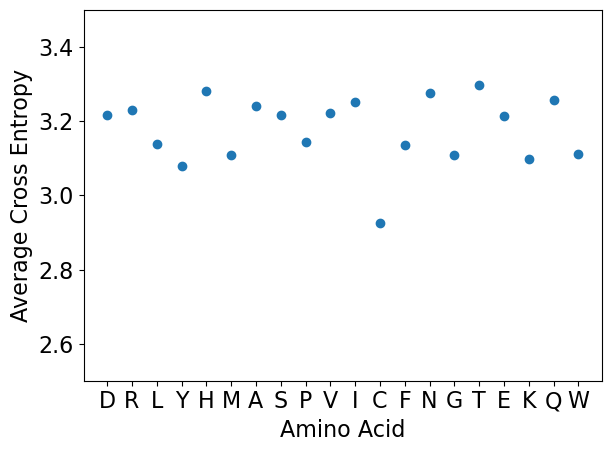

In [8]:
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 16}

plt.rc('font', **font)
plt.scatter(human_aa_counts.keys(), np.array(list(human_aa_loss.values()))/np.array(list(human_aa_counts.values())))
#plt.title("AAs vs Average CE in Human Sequences")
plt.xlabel("Amino Acid")
plt.ylabel("Average Cross Entropy")
plt.ylim((2.5, 3.5))
plt.tight_layout()
plt.plot()
plt.savefig('human.pdf')  

Text(0, 0.5, 'Average Cross Entropy')

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


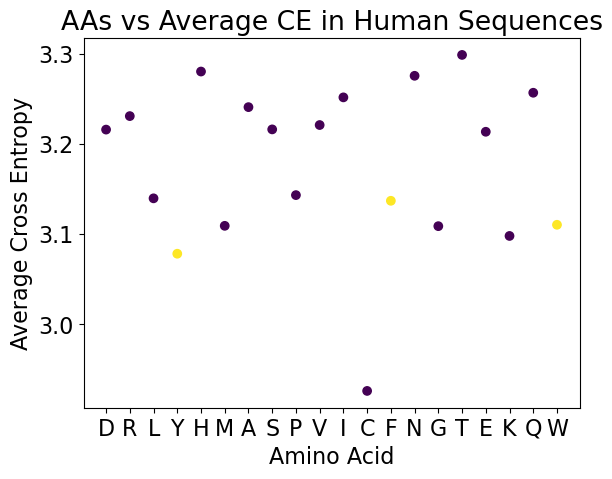

In [10]:
plt.scatter(human_aa_counts.keys(), np.array(list(human_aa_loss.values()))/np.array(list(human_aa_counts.values())), c=all_props[:,0])
plt.title("AAs vs Average CE in Human Sequences")
plt.xlabel("Amino Acid")
plt.ylabel("Average Cross Entropy")

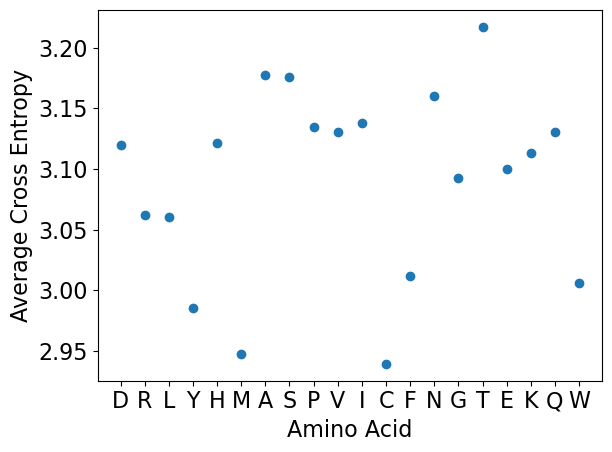

In [11]:

plt.scatter(mouse_aa_counts.keys(), np.array(list(mouse_aa_loss.values()))/np.array(list(mouse_aa_counts.values())))
#plt.title("AAs vs Average CE in Mouse Sequences")
plt.xlabel("Amino Acid")
plt.ylabel("Average Cross Entropy")
plt.tight_layout()
plt.plot()
plt.savefig('mouse.pdf')  

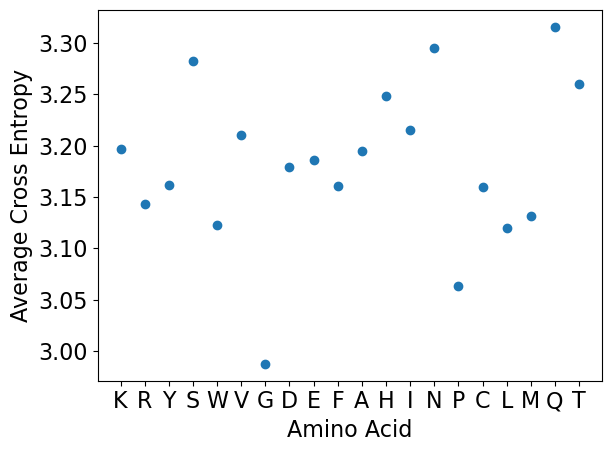

In [53]:

plt.scatter(bac_aa_counts.keys(), np.array(list(bac_aa_loss.values()))/np.array(list(bac_aa_counts.values())))
#plt.title("AAs vs Average CE in Bacteria Sequences")
plt.xlabel("Amino Acid")
plt.ylabel("Average Cross Entropy")
plt.tight_layout()
plt.plot()
plt.savefig('bac.pdf')  